<h1 align = "center"> Semi-supervised Decision Tree</h1>

In [51]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,multilabel_confusion_matrix
import cv2
from tensorflow import keras
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import layers, models, regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.semi_supervised import LabelPropagation
from torchstat import stat
from sklearn.tree import DecisionTreeClassifier

In [84]:
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [85]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [86]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [88]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

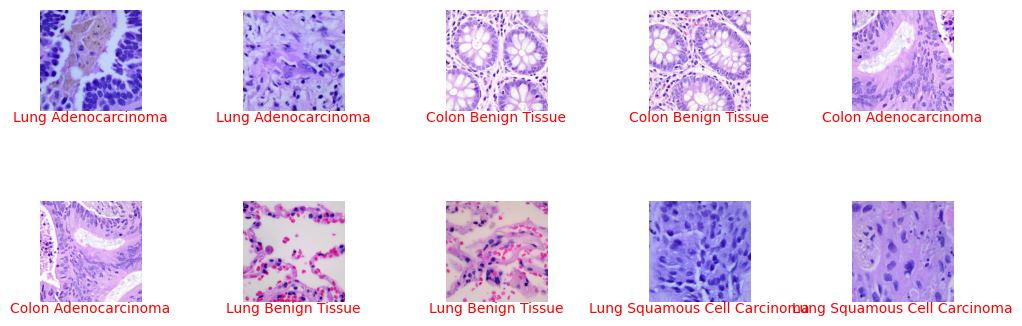

In [89]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [90]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [91]:
# Set the batch size and image dimensions
image_size = (64, 64)  # Adjust this according to your image size

# Create the ImageDataGenerator objects
datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    validationdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [92]:
def get_data_from_generator(generator):
    num_samples = generator.samples

    # Initialize empty arrays to store the features and labels
    X = []
    y = []

    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // generator.batch_size):
        batch_X, batch_y = generator.next()
        X.extend(batch_X)
        y.extend(batch_y)

    # Convert the collected data to numpy arrays
    X = np.array(X)
    y = np.argmax(y,axis=1)

    # Reshape the image data if needed
    if len(X.shape) > 2:
        X = X.reshape(-1, *X.shape[1:])

    return X.reshape(X.shape[0], -1), y

In [93]:
print("TRAIN:")
trainX,trainY = get_data_from_generator(train_generator)
print(len(trainX),len(trainY))

print("VALIDATION:")
validationX,validationY = get_data_from_generator(validation_generator)
print(len(validationX),len(validationY))

print("TEST:")
testX,testY = get_data_from_generator(test_generator)
print(len(testX),len(testY))
print(len(trainX[0]))

TRAIN:
20000 20000
VALIDATION:
2500 2500
TEST:
2500 2500
12288


In [117]:
labeled_train_df,unlabeled_train_df = train_test_split(traindf,random_state=25,train_size=0.25,stratify = traindf["Labels"])

In [118]:
labeled_train_generator = datagen.flow_from_dataframe(
    labeled_train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

unlabeled_train_generator = datagen.flow_from_dataframe(
    unlabeled_train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

Found 5000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


In [119]:
print("TRAIN LABELED DATASET:")
labeled_trainX,labeled_trainY = get_data_from_generator(labeled_train_generator)
print(len(labeled_trainX),len(labeled_trainY))

TRAIN LABELED DATASET:
5000 5000


In [120]:
print("TRAIN UNLABELED DATASET:")
unlabeled_trainX,unlabeled_trainY = get_data_from_generator(unlabeled_train_generator)
print(len(unlabeled_trainX),len(unlabeled_trainY))

TRAIN UNLABELED DATASET:
15000 15000


In [121]:
classifier = DecisionTreeClassifier(max_depth=10,criterion='entropy',min_samples_split=100)
classifier.fit(labeled_trainX,labeled_trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=100)

In [122]:
def getSelectedImageIndexes(probs):
    image_index = []
    selected_probs = []
    for i in range(len(probs)):
        selcted = max(probs[i])
        if selcted >= 0.7:
            selected_probs.append(selcted)
    for i in range(len(np.argsort(selected_probs))):
        image_index.append((np.argsort(selected_probs)[i]))
    return image_index

In [123]:
def getScoreCard():
    y_val_pred1 = classifier.predict(validationX)
    val_accuracy1 = accuracy_score(validationY, y_val_pred1)

    # Evaluate the model on the test set
    y_test_pred1 = classifier.predict(testX)
    test_accuracy1 = accuracy_score(testY, y_test_pred1)

    train_accuracy1 = accuracy_score(labeled_trainY,classifier.predict(labeled_trainX))
    overfitting = round(((train_accuracy1-test_accuracy1)/train_accuracy1)*100,2)
    numbers = [val_accuracy1,test_accuracy1]
    labels = ["Validation","Test"]
    print("-----------------------------")
    print('| {:>10s} | {:>10s} |'.format(*labels))
    print('| {:>10.4f} | {:>10.4f} |'.format(*numbers))
    print("-------------------------------")

In [124]:
iteration = 0
last_iteration = False
alpha = 0.25

while unlabeled_trainX.shape[0] > 0:
    print("Iteration::" + str(iteration))
    iteration += 1
    total_items = 0
    if unlabeled_trainX.shape[0] <= 100:
        total_items = unlabeled_trainX.shape[0]
        last_iteration = True
    else:
        total_items = int(unlabeled_trainX.shape[0] * alpha) 
    if total_items == 0:
        break
    classifier.fit(labeled_trainX,labeled_trainY)
    unlabeled_train_pridictions = classifier.predict(unlabeled_trainX)
    unlabeled_train_probs = classifier.predict_proba(unlabeled_trainX)
    print("unlabeled_train_probs:"+str(len(unlabeled_train_probs)))
    sorted_images = getSelectedImageIndexes(unlabeled_train_probs)
    print("sorted images:"+str(len(sorted_images)))

    for i in range(total_items):
        image_index  = sorted_images[i]
        labeled_trainX = np.concatenate((labeled_trainX,[unlabeled_trainX[image_index]]))
        labeled_trainY = np.concatenate((labeled_trainY,[unlabeled_train_pridictions[image_index]]))
    unlabeled_trainX = unlabeled_trainX[sorted_images[int(len(unlabeled_train_pridictions)*alpha):]]    
    getScoreCard()
    if last_iteration: 
        break

Iteration::0
unlabeled_train_probs:15000
sorted images:10740
-----------------------------
| Validation |       Test |
|     0.6804 |     0.6792 |
-------------------------------
Iteration::1
unlabeled_train_probs:6990
sorted images:5991
-----------------------------
| Validation |       Test |
|     0.6928 |     0.6744 |
-------------------------------
Iteration::2
unlabeled_train_probs:4244
sorted images:3614
-----------------------------
| Validation |       Test |
|     0.6920 |     0.6708 |
-------------------------------
Iteration::3
unlabeled_train_probs:2553
sorted images:2230
-----------------------------
| Validation |       Test |
|     0.6916 |     0.6688 |
-------------------------------
Iteration::4
unlabeled_train_probs:1592
sorted images:1381
-----------------------------
| Validation |       Test |
|     0.6916 |     0.6700 |
-------------------------------
Iteration::5
unlabeled_train_probs:983
sorted images:859
-----------------------------
| Validation |       Test 

IndexError: list index out of range

In [126]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(testX)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['y'] = testY
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26735404 0.05668985 0.01239925]


/var/folders/_8/v_k1l3v15lgdd2d4xvnt3kzc0000gn/T/ipykernel_6588/2115168563.py:3: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='pca-one', ylabel='pca-two'>

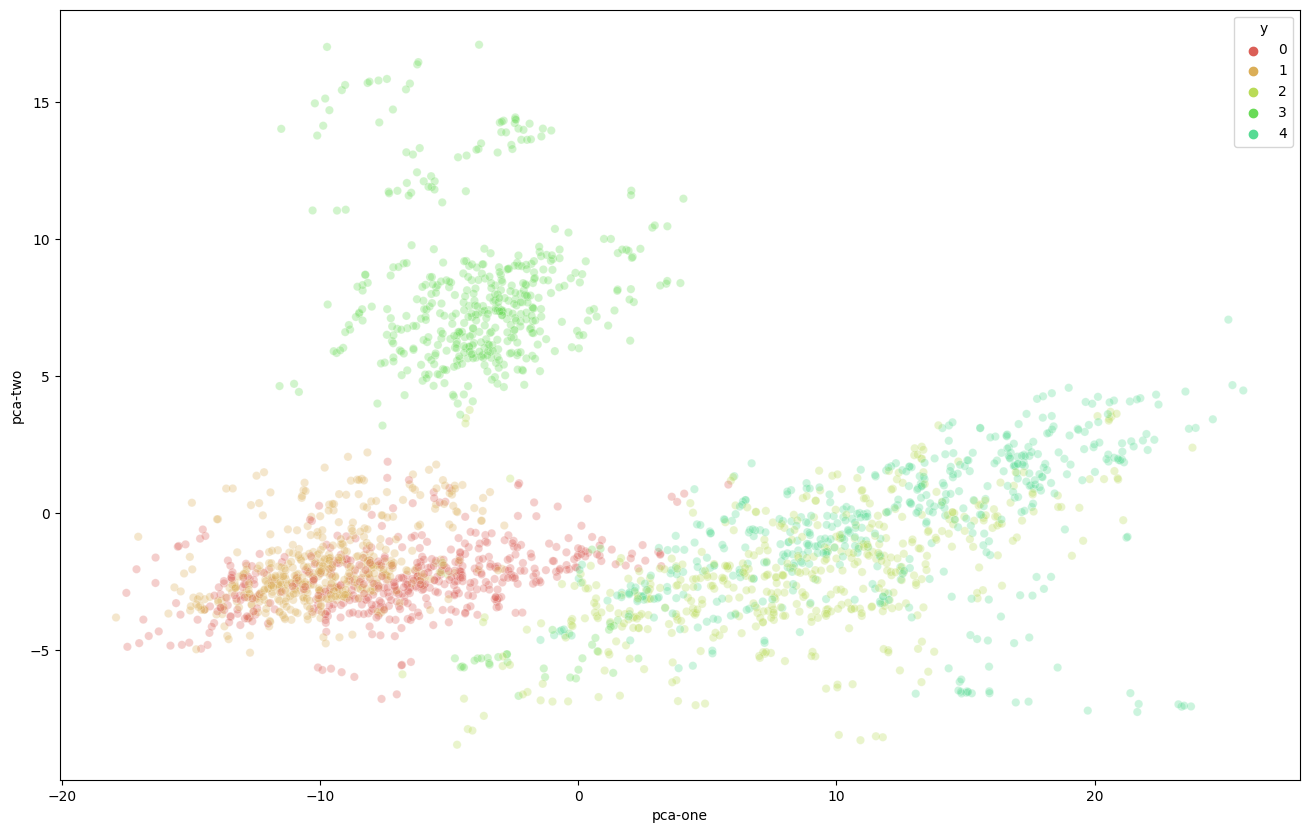

In [127]:
rndperm = np.random.permutation(testX.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

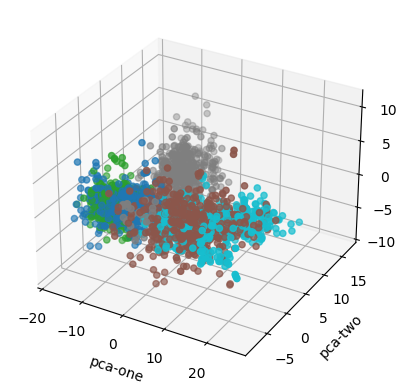

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()